# Imports

In [3]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import keras_nlp

# Load the data

In [4]:
imdb = tfds.load("imdb_reviews", as_supervised=True, download=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.K8R56D_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.K8R56D_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.K8R56D_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [5]:
train_dataset, test_dataset = imdb['train'], imdb['test']

# Prepare

In [6]:
VOCAB_SIZE = 10000
MAX_LENGTH = 120
PADDING_TYPE = 'pre'
TRUNC_TYPE = 'post'

In [7]:
# Instantiate the vectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)

# Get the string inputs and integer outputs of the training set
train_reviews = train_dataset.map(lambda review, label: review)

# Generate the vocabulary based only on the training set
vectorize_layer.adapt(train_reviews)

# Delete because it's no longer needed
del train_reviews

In [8]:
def preprocessing_fn(dataset):
  '''Generates padded sequences from a tf.data.Dataset'''

  # Apply the vectorization layer to the string features
  dataset_sequences = dataset.map(
      lambda text, label: (vectorize_layer(text), label)
      )

  # Put all elements in a single ragged batch
  dataset_sequences = dataset_sequences.ragged_batch(
      batch_size=dataset_sequences.cardinality()
      )

  # Output a tensor from the single batch. Extract the sequences and labels.
  sequences, labels = dataset_sequences.get_single_element()

  # Pad the sequences
  padded_sequences = tf.keras.utils.pad_sequences(
      sequences.numpy(),
      maxlen=MAX_LENGTH,
      truncating=TRUNC_TYPE,
      padding=PADDING_TYPE
      )

  # Convert back to a tf.data.Dataset
  padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)
  labels = tf.data.Dataset.from_tensor_slices(labels)

  # Combine the padded sequences and labels
  dataset_vectorized = tf.data.Dataset.zip(padded_sequences, labels)

  return dataset_vectorized

In [9]:
# Preprocess the train and test data
train_dataset_vectorized = train_dataset.apply(preprocessing_fn)
test_dataset_vectorized = test_dataset.apply(preprocessing_fn)

In [10]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Optimize and batch the datasets for training
train_dataset_final = (train_dataset_vectorized
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )

# Plot history

In [11]:
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'o-', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'o-', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'o-', label='Training Loss')
  ax[1].plot(epochs, val_loss, 'o-', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()

# Flatten

In [14]:
# Param
EMBEDDING_DIM = 16
DENSE_DIM = 6

# Model with a Flatten layer:
model_flatten = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_flatten.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_flatten.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 120, 16)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1920)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │          11,526 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 171,533 (670.05 KB)

 Trainable params: 171,533 (670.05 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
NUM_EPOCHS = 10

history_flatten = model_flatten.fit(
    train_dataset_final,
    epochs=NUM_EPOCHS,
    validation_data=test_dataset_final
)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6272 - loss: 0.6155 - val_accuracy: 0.8245 - val_loss: 0.3864
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8718 - loss: 0.3028 - val_accuracy: 0.8149 - val_loss: 0.4231
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9440 - loss: 0.1656 - val_accuracy: 0.8116 - val_loss: 0.4908
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9885 - loss: 0.0539 - val_accuracy: 0.8094 - val_loss: 0.5806
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9971 - loss: 0.0198 - val_accuracy: 0.8038 - val_loss: 0.6541
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9988 - loss: 0.0092 - val_accuracy: 0.7840 - val_loss: 0.7803
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9992 - loss: 0.0057 - val_accuracy: 0.7986 - val_loss: 0.8015
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9998 - loss: 0.0013 - val_accuracy: 0.

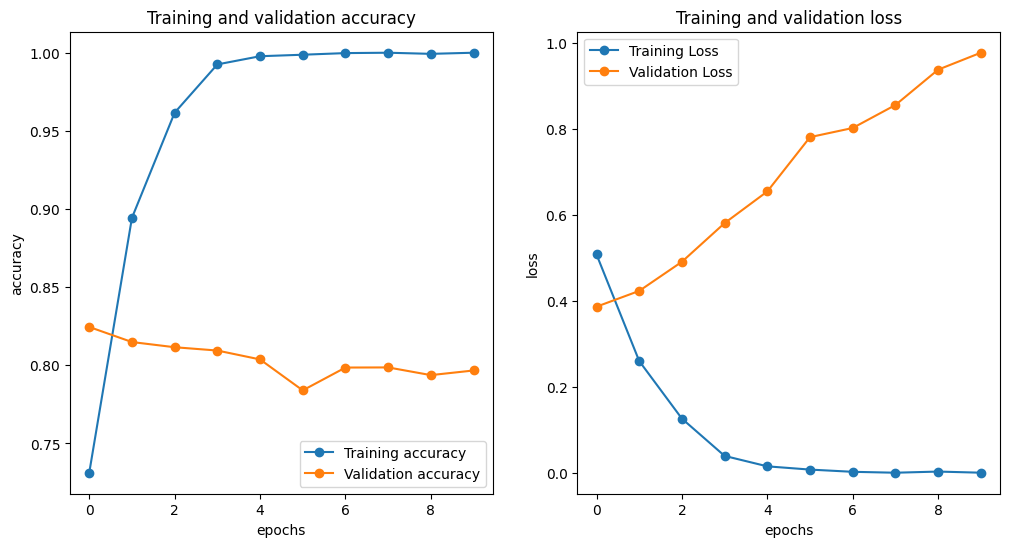

In [19]:
plot_loss_acc(history_flatten)

# LSTM

In [23]:
# Params
EMBEDDING_DIM = 16
LSTM_DIM = 32
DENSE_DIM = 6

# Model with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_DIM)),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 120, 16)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 64)                  │          12,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 6)                   │             390 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 172,941 (675.55 KB)

 Trainable params: 172,941 (675.55 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
NUM_EPOCHS = 10

history_lstm = model_lstm.fit(
    train_dataset_final,
    epochs=NUM_EPOCHS,
    validation_data=test_dataset_final
)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.6604 - loss: 0.5763 - val_accuracy: 0.8285 - val_loss: 0.3878
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.8719 - loss: 0.3131 - val_accuracy: 0.8244 - val_loss: 0.4024
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9050 - loss: 0.2453 - val_accuracy: 0.8117 - val_loss: 0.4600
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9251 - loss: 0.1967 - val_accuracy: 0.8064 - val_loss: 0.6037
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.9406 - loss: 0.1655 - val_accuracy: 0.8063 - val_loss: 0.6037
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.9471 - loss: 0.1406 - val_accuracy: 0.7966 - val_loss: 0.5796
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9641 - loss: 0.1096 - val_accuracy: 0.7942 - val_loss: 0.6196
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.9679 - loss: 0.0969 - 

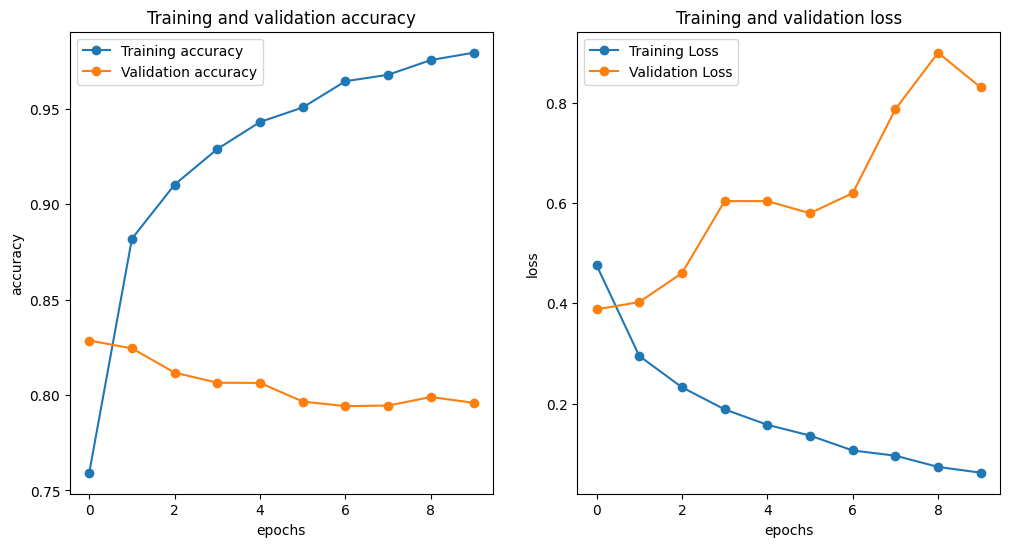

In [25]:
plot_loss_acc(history_lstm)

# GRU

In [26]:
# Params
EMBEDDING_DIM = 16
GRU_DIM = 32
DENSE_DIM = 6

# Model with GRU

model_gru = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(GRU_DIM)),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_gru.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_gru.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 120, 16)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 64)                  │           9,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 6)                   │             390 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 169,997 (664.05 KB)

 Trainable params: 169,997 (664.05 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
NUM_EPOCHS = 10

history_gru = model_gru.fit(
    train_dataset_final,
    epochs=NUM_EPOCHS,
    validation_data=(test_dataset_final)
)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.5449 - loss: 0.6793 - val_accuracy: 0.6204 - val_loss: 0.6667
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.6403 - loss: 0.6294 - val_accuracy: 0.7803 - val_loss: 0.4859
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.8157 - loss: 0.4186 - val_accuracy: 0.8144 - val_loss: 0.4208
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.8717 - loss: 0.3165 - val_accuracy: 0.8140 - val_loss: 0.4516
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9036 - loss: 0.2509 - val_accuracy: 0.8149 - val_loss: 0.4412
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9210 - loss: 0.2119 - val_accuracy: 0.8140 - val_loss: 0.4723
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9407 - loss: 0.1701 - val_accuracy: 0.8014 - val_loss: 0.6090
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9549 - loss: 0.1356 - 

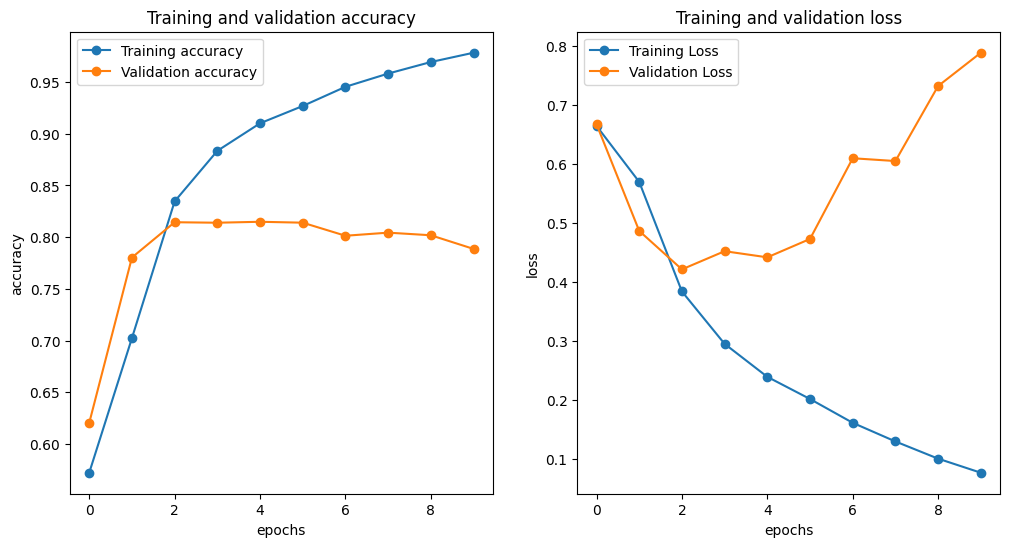

In [28]:
plot_loss_acc(history_gru)

# Convolution

In [33]:
# Params
EMBEDDING_DIM = 16
FILTERS = 128
KERNEL_SIZE = 5
DENSE_DIM = 6

# Model with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Conv1D(FILTERS, KERNEL_SIZE, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_conv.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_conv.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 120, 16)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 116, 128)            │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 6)                   │             774 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 171,149 (668.55 KB)

 Trainable params: 171,149 (668.55 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
NUM_EPOCHS = 10

history_conv = model_conv.fit(
    train_dataset_final,
    epochs=NUM_EPOCHS,
    validation_data=(test_dataset_final)
)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6776 - loss: 0.6000 - val_accuracy: 0.8243 - val_loss: 0.4583
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8632 - loss: 0.3780 - val_accuracy: 0.8262 - val_loss: 0.3928
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8985 - loss: 0.2618 - val_accuracy: 0.8206 - val_loss: 0.4211
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9238 - loss: 0.2102 - val_accuracy: 0.8108 - val_loss: 0.5068
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9413 - loss: 0.1738 - val_accuracy: 0.8065 - val_loss: 0.5848
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9545 - loss: 0.1461 - val_accuracy: 0.8042 - val_loss: 0.6151
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9641 - loss: 0.1193 - val_accuracy: 0.8022 - val_loss: 0.7394
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9745 - loss: 0.0957 - val_accuracy: 0.

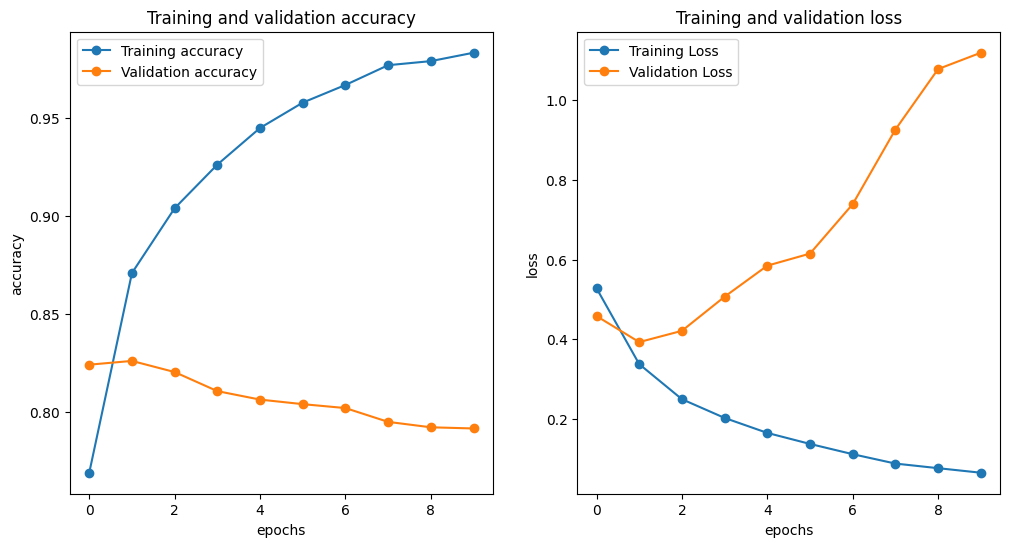

In [35]:
plot_loss_acc(history_conv)